In [ ]:
!pip install scikeras
!pip install plot_keras_history
from __future__ import print_function, division
import os
import re
import sys
import random

import pandas as pd
import numpy as np

# Đổi toàn bộ import từ keras sang tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, Reshape, Dense,
    Dropout, Flatten, MaxPooling1D, Input, Concatenate, LSTM, Bidirectional
)
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical

from numpy import array, argmax, linalg as la
from numpy.linalg import eig

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from lightgbm.sklearn import LGBMClassifier
# from sklearn.externals import joblib  # deprecated in newer scikit-learn versions

import matplotlib.pyplot as plt
from plot_keras_history import plot_history

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.39-py3-none-any.whl size=10667 sha256=e97a67ac19be24a0897a4f23d2830d28a957d23b1b256fed301f21d67da922bd
  Stored in directory: /root/.cache/pip/wheels/03/3e/64/c18638ae75cbffd7c5aaf2abef32fa6050c060b4fde0c0bef6
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.1.4-py3-none-any.whl size=324285 sha256=223bb6f390d9ce00c650e4df565405b8f131f87ebe873e21efcf06c35ef01b61
  Stored in directory: /root/.cache/pip/wheels/5c/64/72/7d3cf6d961a77d1bdd8486046f45c1eb4a3516b570f7258e29
  Created wheel for compress-json: filename=compress_json-1.1.1-py3-none-any.whl size=6598 sha256=27212610a1b249e453134369f27c2069f3685ead6725b892e84ffce26ec309c2
  Stored in directory: /root/.cache/pip/wheels/be/d3/03/626b5d7f1d734

In [ ]:
"""Data Input"""

def parse_stream(f, comment=b'#'):
    name = None
    sequence = []
    for line in f:
        if line.startswith(comment):
            continue
        line = line.strip()
        if line.startswith(b'>'):
            if name is not None:
                yield name, b''.join(sequence)
            name = line[1:]
            sequence = []
        else:
            sequence.append(line.upper())
    if name is not None:
        yield name, b''.join(sequence)

import os

def fasta2csv(inFasta):
    # Đọc file FASTA (được giả định là 2 dòng 1 mẫu: 1 dòng ID, 1 dòng trình tự)
    FastaRead = pd.read_csv(inFasta, header=None)
    print(FastaRead.shape)
    print(FastaRead.head())

    seqNum = int(FastaRead.shape[0] / 2)

    output_path = "testFasta.csv"
    with open(output_path, "w") as csvFile:
        csvFile.write("PID,Seq\n")
        for i in range(seqNum):
            pid = str(FastaRead.iloc[2 * i, 0])
            seq = str(FastaRead.iloc[2 * i + 1, 0])
            csvFile.write(f"{pid},{seq}\n")

    # Đọc lại file CSV đã tạo
    TrainSeqLabel = pd.read_csv(output_path)

    # Nếu muốn xóa file sau khi đọc, có thể thêm:
    if os.path.exists(output_path):
        os.remove(output_path)

    return TrainSeqLabel

inFastaTrain="/content/Train_set.fasta"
inFastaTest="/content/Independent_test_converted.fasta"

In [ ]:
mainTrain = fasta2csv(inFastaTrain)
mainTest = fasta2csv(inFastaTest)

(4748, 1)
                                                   0
0                              >1pos|ACP20mainTest|1
1  CETWRTETTGATGQASSLLSGRLLEQKAASCHNSYIVLCIENSFMT...
2                              >2pos|ACP20mainTest|1
3  DERCTIIIHPGSPCDPSDCVQYCYAEYNGVGKCIASKPGRSANCMC...
4                              >3pos|ACP20mainTest|1
(2690, 1)
                       0
0  >1pos|ACP20mainTest|1
1            FLWWLFKWAWK
2  >2pos|ACP20mainTest|1
3          FAKLAKKALAKLL
4  >3pos|ACP20mainTest|1


In [ ]:
"""handle y"""

# Train set
mainTrain["Tags"] = mainTrain["PID"].apply(lambda pid: 1 if str(pid)[-1] == "1" else 0)

# Test set
mainTest["Tags"] = mainTest["PID"].apply(lambda pid: 1 if str(pid)[-1] == "1" else 0)

# Convert to numpy array
ACP_y_train = mainTrain["Tags"].values
ACP_y_test = mainTest["Tags"].values

ACP_y_train_ = np.array(ACP_y_train, dtype=int)
ACP_y_test_ = np.array(ACP_y_test, dtype=int)

In [ ]:
"""get x_train_oe"""

x_train = {}
protein_index = 1
for line in mainTrain["Seq"]:
  x_train[protein_index] = line
  protein_index = protein_index + 1
maxlen_train = max(len(x) for x in x_train.values())

x_test = {}
protein_index = 1
for line in mainTest["Seq"]:
  x_test[protein_index] = line
  protein_index = protein_index + 1
maxlen_test = max(len(x) for x in x_test.values())

maxlen = max(maxlen_train,maxlen_test)

In [ ]:
#Convert amino acids to vectors
def OE(seq_temp):
    seq = seq_temp
    chars = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
    fea = []
    tem_vec =[]
    #k = 6
    for i in range(len(seq)):
        if seq[i] =='A':
            tem_vec = [1]
        elif seq[i]=='C':
            tem_vec = [2]
        elif seq[i]=='D':
            tem_vec = [3]
        elif seq[i]=='E' or seq[i]=='U':
            tem_vec = [4]
        elif seq[i]=='F':
            tem_vec = [5]
        elif seq[i]=='G':
            tem_vec = [6]
        elif seq[i]=='H':
            tem_vec = [7]
        elif seq[i]=='I':
            tem_vec = [8]
        elif seq[i]=='K':
            tem_vec = [9]
        elif seq[i]=='L':
            tem_vec = [10]
        elif seq[i]=='M' or seq[i]=='O':
            tem_vec = [11]
        elif seq[i]=='N':
            tem_vec = [12]
        elif seq[i]=='P':
            tem_vec = [13]
        elif seq[i]=='Q':
            tem_vec = [14]
        elif seq[i]=='R':
            tem_vec = [15]
        elif seq[i]=='S':
            tem_vec = [16]
        elif seq[i]=='T':
            tem_vec = [17]
        elif seq[i]=='V':
            tem_vec = [18]
        elif seq[i]=='W':
            tem_vec = [19]
        elif seq[i]=='X' or seq[i]=='B' or seq[i]=='Z':
            tem_vec = [20]
        elif seq[i]=='Y':
            tem_vec = [21]
        #fea = fea + tem_vec +[i]
        fea.append(tem_vec)
    return fea

x_train_oe = []
for i in x_train:
  oe_feature = OE(x_train[i])
  x_train_oe.append(oe_feature)
  #print(protein_seq_dict[i])

x_test_oe = []
for i in x_test:
  oe_feature = OE(x_test[i])
  x_test_oe.append(oe_feature)

x_train_ = np.array(pad_sequences(x_train_oe, padding='post', maxlen=maxlen))
x_test_ = np.array(pad_sequences(x_test_oe, padding='post', maxlen=maxlen))

In [ ]:
"""handcraft

AAC
"""

handcraft_AAC_train = [[0] * 21 for _ in range(len(x_train_oe))]
for row in range(len(x_train_oe)):
  seq = x_train_oe[row]
  for i in seq:
    col = i[0]-1
    handcraft_AAC_train[row][col] += 1/len(seq)
hc_AAC_train = np.array(handcraft_AAC_train)

handcraft_AAC_test = [[0] * 21 for _ in range(len(x_test_oe))]
for row in range(len(x_test_oe)):
  seq = x_test_oe[row]
  for i in seq:
    col = i[0]-1
    handcraft_AAC_test[row][col] += 1/len(seq)
hc_AAC_test = np.array(handcraft_AAC_test)


In [ ]:
"""DPC"""

comb = []
for i in range(1,22):
  for j in range(i,22):
    comb.append([i,j])
comb_index = {}
for i in range(len(comb)):
  comb_index[tuple(comb[i])] = i

handcraft_DPC_train = [[0] * len(comb) for _ in range(len(x_train_oe))]
for row in range(len(x_train_oe)):
  seq = x_train_oe[row]
  for i in range(len(seq)-1):
    a = sorted([seq[i][0],seq[i+1][0]])
    index = comb_index[tuple(a)]
    handcraft_DPC_train[row][index] += 1/(len(seq)-1)
hc_DPC_train = np.array(handcraft_DPC_train)

handcraft_DPC_test = [[0] * len(comb) for _ in range(len(x_test_oe))]
for row in range(len(x_test_oe)):
  seq = x_test_oe[row]
  for i in range(len(seq)-1):
    a = sorted([seq[i][0],seq[i+1][0]])
    index = comb_index[tuple(a)]
    handcraft_DPC_test[row][index] += 1/(len(seq)-1)
hc_DPC_test = np.array(handcraft_DPC_test)

In [ ]:
"""CKS"""

def readFasta(file):
    if os.path.exists(file) == False:
        print('Error: "' + file + '" does not exist.')
        sys.exit(1)

    with open(file) as f:
        records = f.read()

    if re.search('>', records) == None:
        print('The input file seems not in fasta format.')
        sys.exit(1)

    records = records.split('>')[1:]
    myFasta = []
    for fasta in records:
        array = fasta.split('\n')
        name, sequence = array[0].split()[0], re.sub('[^ARNDCQEGHILKMFPSTWYV-]', '-', ''.join(array[1:]).upper())
        myFasta.append([name, sequence])

    return myFasta

def generateGroupPairs(groupKey):
    gPair = {}
    for key1 in groupKey:
        for key2 in groupKey:
            gPair[key1+'.'+key2] = 0
    return gPair


def CKSAAGP(fastas, gap = 5, **kw):

    group = {
        'alphaticr': 'GAVLMI',
        'aromatic': 'FYW',
        'postivecharger': 'KRH',
        'negativecharger': 'DE',
        'uncharger': 'STCPNQ'
    }

    AA = 'ARNDCQEGHILKMFPSTWYV'

    groupKey = group.keys()

    index = {}
    for key in groupKey:
        for aa in group[key]:
            index[aa] = key

    gPairIndex = []
    for key1 in groupKey:
        for key2 in groupKey:
            gPairIndex.append(key1+'.'+key2)

    encodings = []
    header = ['#']
    for g in range(gap + 1):
        for p in gPairIndex:
            header.append(p+'.gap'+str(g))
    encodings.append(header)

    for i in fastas:
        name, sequence = i[0], re.sub('-', '', i[1])
        code = [name]
        for g in range(gap + 1):
            gPair = generateGroupPairs(groupKey)
            sum = 0
            for p1 in range(len(sequence)):
                p2 = p1 + g + 1
                if p2 < len(sequence) and sequence[p1] in AA and sequence[p2] in AA:
                    gPair[index[sequence[p1]]+'.'+index[sequence[p2]]] = gPair[index[sequence[p1]]+'.'+index[sequence[p2]]] + 1
                    sum = sum + 1

            if sum == 0:
                for gp in gPairIndex:
                    code.append(0)
            else:
                for gp in gPairIndex:
                    code.append(gPair[gp] / sum)

        encodings.append(code)

    return encodings

In [ ]:
handcraft_CKSAAGP_train = CKSAAGP(readFasta(inFastaTrain))
handcraft_CKS_train = []
for i in range(1,len(handcraft_CKSAAGP_train)):
  handcraft_CKS_train.append(handcraft_CKSAAGP_train[i][1:])
hc_CKS_train = np.array(handcraft_CKS_train)

handcraft_CKSAAGP_test = CKSAAGP(readFasta(inFastaTest))
handcraft_CKS_test = []
for i in range(1,len(handcraft_CKSAAGP_test)):
  handcraft_CKS_test.append(handcraft_CKSAAGP_test[i][1:])
hc_CKS_test = np.array(handcraft_CKS_test)

In [ ]:
"""kmer"""

def TransDict_from_list(groups):
  transDict = dict()
  tar_list = ['0', '1', '2', '3', '4', '5', '6']
  result = {}
  index = 0
  for group in groups:
    g_members = sorted(group)  # Alphabetically sorted list
    for c in g_members:
        # print('c' + str(c))
        # print('g_members[0]' + str(g_members[0]))
        result[c] = str(tar_list[index])  # K:V map, use group's first letter as represent.
    index = index + 1
  return result

In [ ]:
def translate_sequence(seq, TranslationDict):
  '''
  Given (seq) - a string/sequence to translate,
  Translates into a reduced alphabet, using a translation dict provided
  by the TransDict_from_list() method.
  Returns the string/sequence in the new, reduced alphabet.
  Remember - in Python string are immutable..
  '''
  import string
  from_list = []
  to_list = []
  for k, v in TranslationDict.items():
      from_list.append(k)
      to_list.append(v)
  # TRANS_seq = seq.translate(str.maketrans(zip(from_list,to_list)))
  TRANS_seq = seq.translate(str.maketrans(str(from_list), str(to_list)))
  # TRANS_seq = maketrans( TranslationDict, seq)
  return TRANS_seq

In [ ]:
def get_3_protein_trids():
  nucle_com = []
  chars = ['0', '1', '2', '3', '4', '5', '6']
  base = len(chars)
  end = len(chars) ** 3
  for i in range(0, end):
      n = i
      ch0 = chars[n % base]
      n = n / base
      ch1 = chars[int(n % base)]
      n = n / base
      ch2 = chars[int(n % base)]
      nucle_com.append(ch0 + ch1 + ch2)
  return nucle_com
def get_4_nucleotide_composition(tris, seq, pythoncount=True):
  seq_len = len(seq)
  tri_feature = [0] * len(tris)
  k = len(tris[0])
  note_feature = [[0 for cols in range(len(seq) - k + 1)] for rows in range(len(tris))]
  if pythoncount:
      for val in tris:
          num = seq.count(val)
          tri_feature.append(float(num) / seq_len)
  else:
      # tmp_fea = [0] * len(tris)
      for x in range(len(seq) + 1 - k):
          kmer = seq[x:x + k]
          if kmer in tris:
              ind = tris.index(kmer)
              # tmp_fea[ind] = tmp_fea[ind] + 1
              note_feature[ind][x] = note_feature[ind][x] + 1
      # tri_feature = [float(val)/seq_len for val in tmp_fea]    #tri_feature type:list len:256
      u, s, v = la.svd(note_feature)
      for i in range(len(s)):
          tri_feature = tri_feature + u[i] * s[i] / seq_len
      # print tri_feature
      # pdb.set_trace()

  return tri_feature

In [ ]:
def prepare_feature_kmer(infile):
  protein_seq_dict = {}
  protein_index = 1
  with open(infile, 'r') as fp:
    for line in fp:
      if line[0] != '>':
        seq = line[:-1]
        protein_seq_dict[protein_index] = seq
        protein_index = protein_index + 1
  kmer = []
  groups = ['AGV', 'ILFP', 'YMTS', 'HNQW', 'RK', 'DE', 'C']
  group_dict = TransDict_from_list(groups)
  protein_tris = get_3_protein_trids()
  # get protein feature
  # pdb.set_trace()
  for i in protein_seq_dict:  # and protein_fea_dict.has_key(protein) and RNA_fea_dict.has_key(RNA):
    protein_seq = translate_sequence(protein_seq_dict[i], group_dict)
    # print('oe:',shape(oe_feature))
    # pdb.set_trace()
    # RNA_tri_fea = get_4_nucleotide_composition(tris, RNA_seq, pythoncount=False)
    protein_tri_fea = get_4_nucleotide_composition(protein_tris, protein_seq, pythoncount =False)
    kmer.append(protein_tri_fea)
    protein_index = protein_index + 1
    # chem_fea.append(chem_tmp_fea)
  return np.array(kmer)

In [ ]:
kmer_train = prepare_feature_kmer(inFastaTrain)
kmer_test = prepare_feature_kmer(inFastaTest)

hc_train = np.c_[hc_AAC_train,hc_DPC_train,hc_CKS_train,kmer_train]
hc_train.shape

hc_test = np.c_[hc_AAC_test,hc_DPC_test,hc_CKS_test,kmer_test]
hc_test.shape

(1345, 745)

In [ ]:
"""Train_test_split"""

X_train,X_val,y_train,y_val,HC_train,HC_val = train_test_split(x_train_,ACP_y_train_,hc_train,test_size=0.2,random_state=1)

HC_train.shape

"""Bilstm + new features"""

vocab_size=22
embedding_dim=100

main_input = Input((maxlen,),dtype='int32',name='main_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=True)(main_input)
lstm_out = Bidirectional(LSTM(64))(x)
aux_len = HC_train.shape[1]
aux_input = Input((aux_len,),name='aux_input')
x = layers.concatenate([lstm_out,aux_input])
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
main_output = Dense(1,activation='sigmoid',name='main_output')(x)
model = Model(inputs=[main_input,aux_input],outputs=main_output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5857 - loss: 0.6815 - val_accuracy: 0.7789 - val_loss: 0.5256
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7801 - loss: 0.5031 - val_accuracy: 0.7916 - val_loss: 0.4850
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7856 - loss: 0.4741 - val_accuracy: 0.7768 - val_loss: 0.4846
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8085 - loss: 0.4429 - val_accuracy: 0.7811 - val_loss: 0.4637
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8004 - loss: 0.4438 - val_accuracy: 0.7832 - val_loss: 0.4800
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7973 - loss: 0.4468 - val_accuracy: 0.7916 - val_loss: 0.4673
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8276 - loss: 0.4120 - val_accuracy: 0.7789 - val_loss: 0.4544
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8267 - loss: 0.3904 - val_accuracy: 0.7789 - v

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

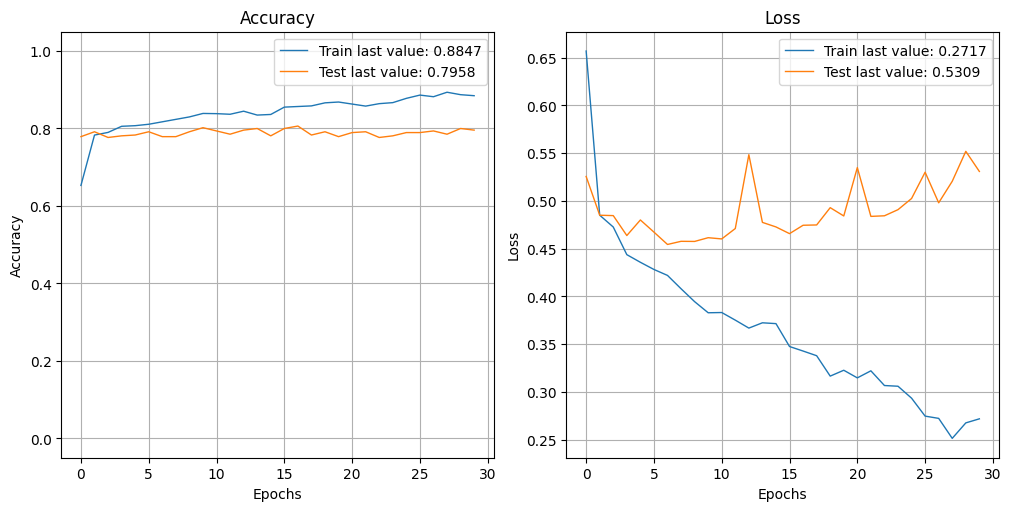

In [ ]:
#train the model
hist = model.fit(x={'main_input':X_train,'aux_input':HC_train}, y= y_train,
                    #class_weight = class_weights_d,
                    epochs=30,
                    verbose=True,
                    validation_data=([X_val,HC_val],y_val),
                    batch_size=64).history

#import joblib

#joblib.dump(model,filename='bilstm_attention_main7632.joblib')

loss, accuracy = model.evaluate(x={'main_input':X_train,'aux_input':HC_train}, y = y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x={'main_input':X_val,'aux_input':HC_val}, y = y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

In [ ]:
"""BiLSTM(lstm)"""

main_input = Input((maxlen,),dtype='int32',name='main_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=True)(main_input)
lstm_out = LSTM(64)(x)
#lstm_out = Bidirectional(LSTM(64))(x)
x = Dropout(0.5)(lstm_out)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
#x = Dense(64,activation='relu')(x)
main_output = Dense(1,activation='sigmoid',name='main_output')(x)
model = Model(inputs=main_input,outputs=main_output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4898 - loss: 0.6934 - val_accuracy: 0.5095 - val_loss: 0.6929
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4947 - loss: 0.6934 - val_accuracy: 0.5095 - val_loss: 0.6926
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5146 - loss: 0.6931 - val_accuracy: 0.6189 - val_loss: 0.6841
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6583 - loss: 0.6410 - val_accuracy: 0.7474 - val_loss: 0.5896
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7520 - loss: 0.5664 - val_accuracy: 0.7179 - val_loss: 0.6077
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7189 - loss: 0.6057 - val_accuracy: 0.5368 - val_loss: 0.6807
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4983 - loss: 0.6778 - val_accuracy: 0.6021 - val_loss: 0.6423
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6770 - loss: 0.6113 - val_accuracy: 0.7579 - v

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

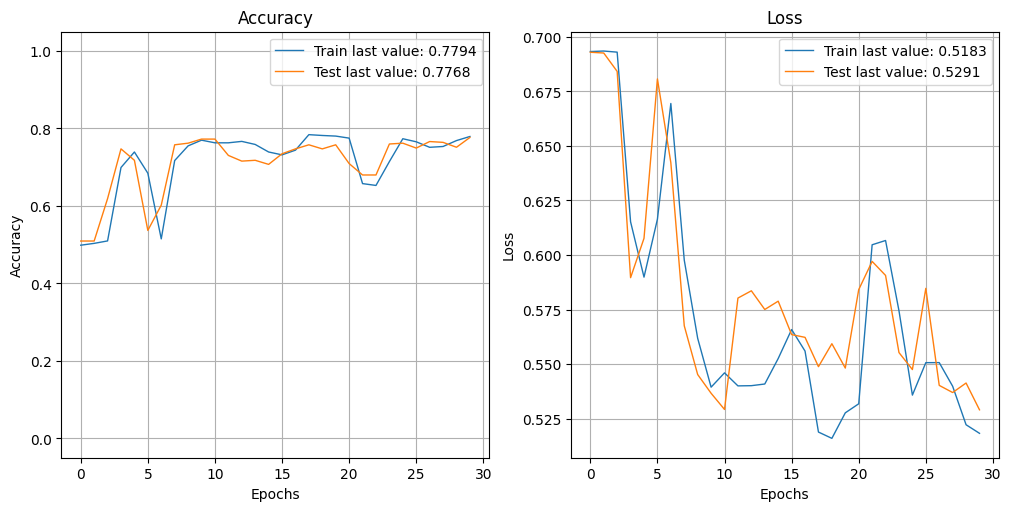

In [ ]:
#train the model
hist = model.fit(x=X_train, y= y_train,
                    #class_weight = class_weights_d,
                    epochs=30,
                    verbose=True,
                    validation_data=(X_val,y_val),
                    batch_size=64).history

#import joblib

#joblib.dump(model,filename='bilstm_attention_main7632.joblib')

loss, accuracy = model.evaluate(x=X_train, y = y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x=X_val, y = y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

In [ ]:
from tensorflow.keras import backend as K, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        # W_regularizer:
        # b_regularizer:
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        # W_constraint:
        # b_constraint:
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
                    self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        '''
        keras.backend.cast(x, dtype):
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())

        '''
        keras.backend.epsilon():
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()   , K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5700 - loss: 0.6835 - val_accuracy: 0.6695 - val_loss: 0.5916
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7656 - loss: 0.5192 - val_accuracy: 0.7832 - val_loss: 0.4876
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7973 - loss: 0.4668 - val_accuracy: 0.7895 - val_loss: 0.4766
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8206 - loss: 0.4367 - val_accuracy: 0.7853 - val_loss: 0.4811
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7957 - loss: 0.4700 - val_accuracy: 0.7621 - val_loss: 0.5127
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7947 - loss: 0.4675 - val_accuracy: 0.8000 - val_loss: 0.4526
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8154 - loss: 0.4296 - val_accuracy: 0.7895 - val_loss: 0.4596
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7990 - loss: 0.4430 - val_accuracy: 0.7874 - v

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

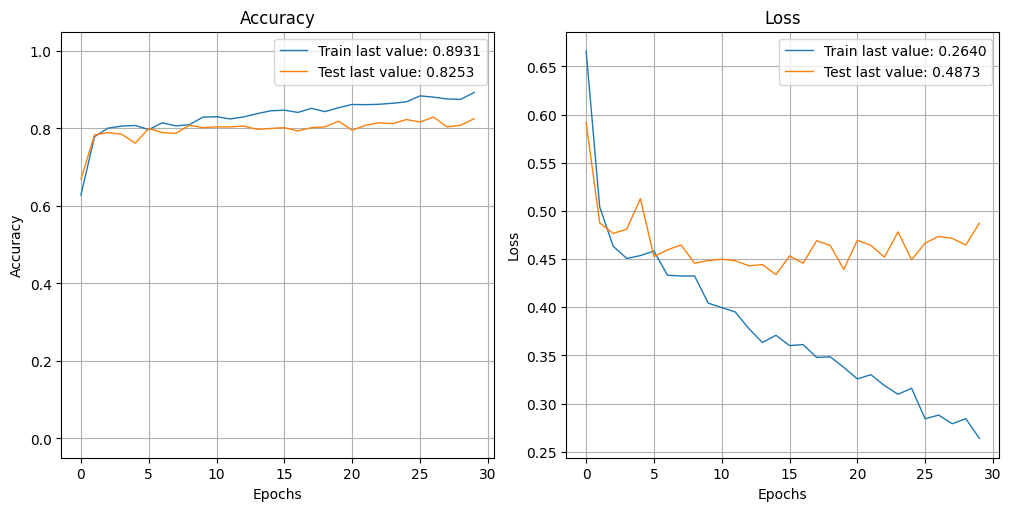

In [ ]:
main_input = Input(shape=(maxlen,), dtype='int32',name='main_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=True)(main_input)
x = Bidirectional(LSTM(100, return_sequences=True))(x)
x = Attention(maxlen)(x)
aux_len = HC_train.shape[1]
aux_input = Input((aux_len,),name='aux_input')
x = layers.concatenate([x,aux_input])
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
#x = Dense(64,activation='relu')(x)
main_output = Dense(1,activation='sigmoid',name='main_output')(x)
model = Model(inputs=[main_input,aux_input], outputs=main_output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x={'main_input':X_train,'aux_input':HC_train}, y= y_train,
                    #class_weight = class_weights_d,
                    epochs=30,
                    verbose=True,
                    validation_data=([X_val,HC_val],y_val),
                    batch_size=64).history

loss, accuracy = model.evaluate(x={'main_input':X_train,'aux_input':HC_train}, y = y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x={'main_input':X_val,'aux_input':HC_val}, y = y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

In [ ]:
model.save("bilstm_attention_main8253.keras")

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5697 - loss: 0.6759 - val_accuracy: 0.7600 - val_loss: 0.5272
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7493 - loss: 0.5320 - val_accuracy: 0.7895 - val_loss: 0.5292
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7871 - loss: 0.5015 - val_accuracy: 0.7832 - val_loss: 0.5006
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7938 - loss: 0.4925 - val_accuracy: 0.7768 - val_loss: 0.5111
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7813 - loss: 0.4952 - val_accuracy: 0.7832 - val_loss: 0.5180
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8018 - loss: 0.4620 - val_accuracy: 0.7768 - val_loss: 0.4996
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7868 - loss: 0.4704 - val_accuracy: 0.7832 - val_loss: 0.4803
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8071 - loss: 0.4599 - val_accuracy: 0.7747 - val_loss: 0.

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

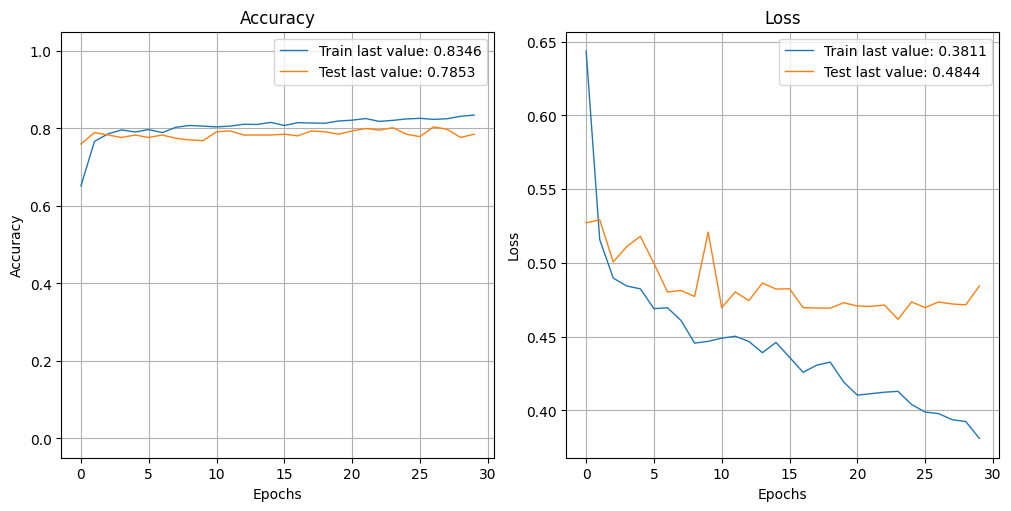

In [ ]:
"""Attention"""

vocab_size=22
embedding_dim=100
main_input = Input(shape=(maxlen,), dtype='int32',name='main_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=True)(main_input)
x = Bidirectional(LSTM(100, return_sequences=True))(x)
x = Attention(maxlen)(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
main_output = Dense(1,activation='sigmoid',name='main_output')(x)
model = Model(inputs=main_input, outputs=main_output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x= X_train, y= y_train,
                    #class_weight = class_weights_d,
                    epochs=30,
                    verbose=True,
                    validation_data=(X_val,y_val),
                    batch_size=64).history

loss, accuracy = model.evaluate(x=X_train, y = y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x=X_val, y = y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

In [ ]:
"""Feature Selection"""

def RF_SelectFeatures(X,y,i):#RadomForest Feature Selection Method

    model = RandomForestClassifier(n_estimators=888,min_samples_leaf=10,random_state=2020,n_jobs=8)
    model.fit(X, y)
    importantFeatures = model.feature_importances_
    K = importantFeatures.argsort()[::-1][:i]
    RF_ALL_K=X[:,K]

    return  RF_ALL_K

def LGBM_SelectFeatures(X,y,i):#Light Gradient Boosting Machine Feature Selection

    model = LGBMClassifier(num_leaves=32,n_estimators=888,max_depth=12,learning_rate=0.16,min_child_samples=50,random_state=2020,n_jobs=8)
    model.fit(X, y)
    importantFeatures = model.feature_importances_
    K = importantFeatures.argsort()[::-1][:i]
    LGB_ALL_K=X[:,K]

    return  LGB_ALL_K



Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5987 - loss: 0.6818 - val_accuracy: 0.6695 - val_loss: 0.6541
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7377 - loss: 0.5376 - val_accuracy: 0.7832 - val_loss: 0.4840
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7978 - loss: 0.4629 - val_accuracy: 0.8000 - val_loss: 0.4879
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8138 - loss: 0.4554 - val_accuracy: 0.7726 - val_loss: 0.4816
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8088 - loss: 0.4397 - val_accuracy: 0.8000 - val_loss: 0.4579
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8129 - loss: 0.4272 - val_accuracy: 0.7895 - val_loss: 0.4602
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8042 - loss: 0.4396 - val_accuracy: 0.7916 - val_loss: 0.4725
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8419 - loss: 0.3917 - val_accuracy: 0.7874 - val_loss: 0.

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

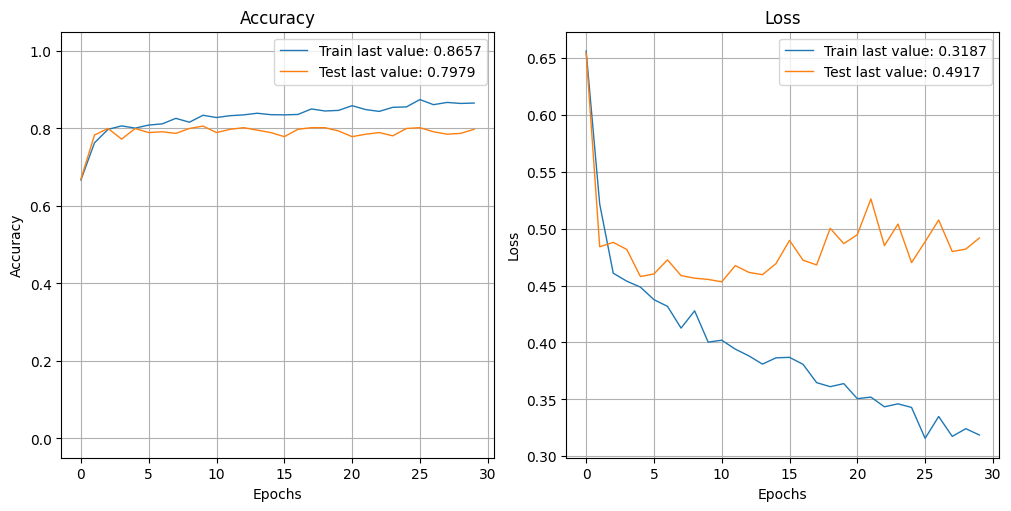

In [ ]:
"""RF selector"""

SF_ALL_K_train=RF_SelectFeatures(hc_train,ACP_y_train_,350)
SF_ALL_K_test=RF_SelectFeatures(hc_test,ACP_y_test_,350)

X_train,X_val,y_train,y_val,HS_train,HS_val = train_test_split(x_train_,ACP_y_train_,SF_ALL_K_train,test_size=0.2,random_state=1)

main_input = Input((maxlen,),dtype='int32',name='main_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=True)(main_input)
lstm_out = Bidirectional(LSTM(64))(x)
aux_len = HS_train.shape[1]
aux_input = Input((aux_len,),name='aux_input')
x = layers.concatenate([lstm_out,aux_input])
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
main_output = Dense(1,activation='sigmoid',name='main_output')(x)
model = Model(inputs=[main_input,aux_input],outputs=main_output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

#train the model
hist = model.fit(x={'main_input':X_train,'aux_input':HS_train}, y= y_train,
                    #class_weight = class_weights_d,
                    epochs=30,
                    verbose=True,
                    validation_data=([X_val,HS_val],y_val),
                    batch_size=64).history

loss, accuracy = model.evaluate(x={'main_input':X_train,'aux_input':HS_train}, y = y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x={'main_input':X_val,'aux_input':HS_val}, y = y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

[LightGBM] [Info] Number of positive: 1205, number of negative: 1169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17298
[LightGBM] [Info] Number of data points in the train set: 2374, number of used features: 662
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507582 -> initscore=0.030331
[LightGBM] [Info] Start training from score 0.030331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5113 - loss: 0.6878 - val_accuracy: 0.7474 - val_loss: 0.5876
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7651 - loss: 0.5487 - val_accuracy: 0.7789 - val_loss: 0.5003
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7924 - loss: 0.4785 - val_accuracy: 0.7874 - val_loss: 0.4846
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8155 - loss: 0.4238 - val_accuracy: 0.7895 - val_loss: 0.4702
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8239 - loss: 0.4310 - val_accuracy: 0.7789 - val_loss: 0.4758
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8030 - loss: 0.4550 - val_accuracy: 0.7811 - val_loss: 0.4711
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8196 - loss: 0.4098 - val_accuracy: 0.7979 - val_loss: 0.4587
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8168 - loss: 0.4289 - val_accuracy: 0.7874 - v

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

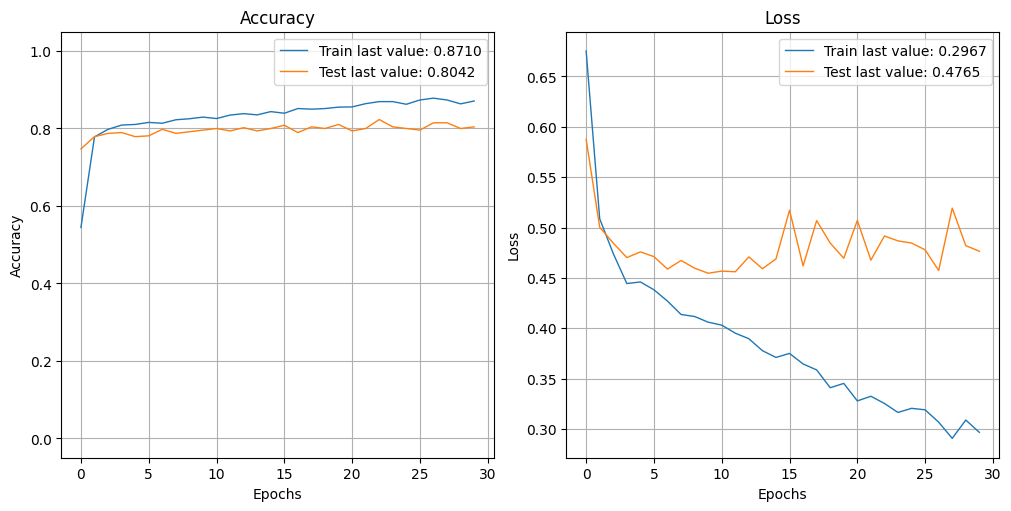

In [ ]:
"""LGBM selector"""
SF_ALL_K_train=LGBM_SelectFeatures(hc_train,ACP_y_train_,350)
SF_ALL_K_test=LGBM_SelectFeatures(hc_test,ACP_y_test_,350)

X_train,X_val,y_train,y_val,HS_train,HS_val = train_test_split(x_train_,ACP_y_train_,SF_ALL_K_train,test_size=0.2,random_state=1)

main_input = Input((maxlen,),dtype='int32',name='main_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=True)(main_input)
lstm_out = Bidirectional(LSTM(64))(x)
aux_len = HS_train.shape[1]
aux_input = Input((aux_len,),name='aux_input')
x = layers.concatenate([lstm_out,aux_input])
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
main_output = Dense(1,activation='sigmoid',name='main_output')(x)
model = Model(inputs=[main_input,aux_input],outputs=main_output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

#train the model
hist = model.fit(x={'main_input':X_train,'aux_input':HS_train}, y= y_train,
                    #class_weight = class_weights_d,
                    epochs=30,
                    verbose=True,
                    validation_data=([X_val,HS_val],y_val),
                    batch_size=64).history

loss, accuracy = model.evaluate(x={'main_input':X_train,'aux_input':HS_train}, y = y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x={'main_input':X_val,'aux_input':HS_val}, y = y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5563 - loss: 0.6895

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5654 - loss: 0.6873 - val_accuracy: 0.7789 - val_loss: 0.5580
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7730 - loss: 0.5214 - val_accuracy: 0.7747 - val_loss: 0.4908
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7990 - loss: 0.4782 - val_accuracy: 0.7937 - val_loss: 0.4773
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8107 - loss: 0.4525 - val_accuracy: 0.7853 - val_loss: 0.4903
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8028 - loss: 0.4625 - val_accuracy: 0.7916 - val_loss: 0.4653
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8239 - loss: 0.4199 - val_accuracy: 0.7958 - val_loss: 0.4500
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8062 - loss: 0.4381 - val_accuracy: 0.7916 - val_loss: 0.4648
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8121 - loss: 0.4264 - val_accuracy: 0.7874 - val_loss: 0.

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8872 - loss: 0.2695
Training Accuracy: 0.8857
Testing Accuracy:  0.7853


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

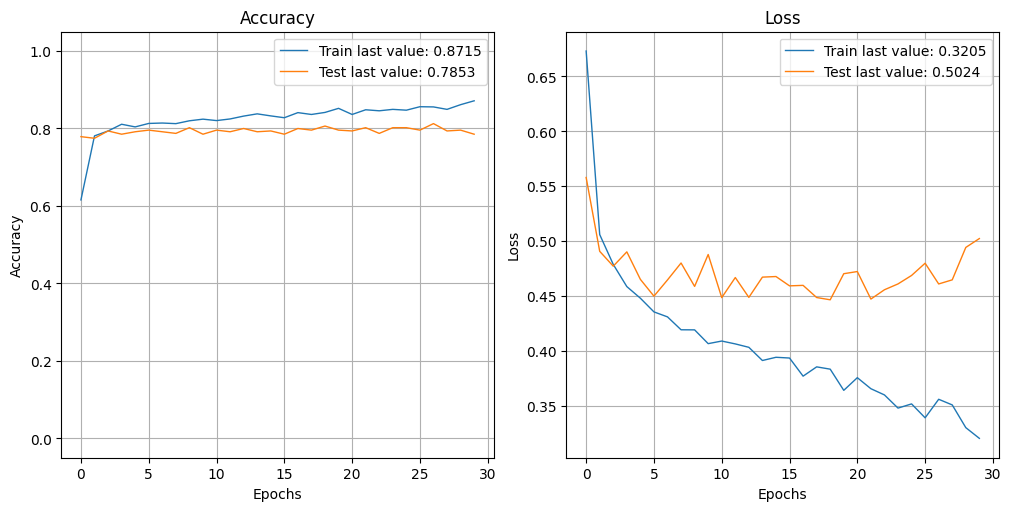

In [ ]:
"""pca"""

def pca(X,k):
  X = X - X.mean(axis = 0)
  X_cov = np.cov(X.T, ddof = 0)
  eigenvalues, eigenvectors = eig(X_cov)
  klarge_index = eigenvalues.argsort()[-k:][::-1]
  k_eigenvectors = eigenvectors[klarge_index]
  return np.dot(X,k_eigenvectors.T)

hc_train_pca = pca(hc_train,148)
hc_test_pca = pca(hc_test,148)

X_train,X_val,y_train,y_val,HS_train,HS_val = train_test_split(x_train_,ACP_y_train_,hc_train_pca,test_size=0.2,random_state=1)

main_input = Input((maxlen,),dtype='int32',name='main_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=True)(main_input)
lstm_out = Bidirectional(LSTM(64))(x)
aux_len = HS_train.shape[1]
aux_input = Input((aux_len,),name='aux_input')
x = layers.concatenate([lstm_out,aux_input])
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
main_output = Dense(1,activation='sigmoid',name='main_output')(x)
model = Model(inputs=[main_input,aux_input],outputs=main_output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

#train the model
hist = model.fit(x={'main_input':X_train,'aux_input':HS_train}, y= y_train,
                    #class_weight = class_weights_d,
                    epochs=30,
                    verbose=True,
                    validation_data=([X_val,HS_val],y_val),
                    batch_size=64).history

loss, accuracy = model.evaluate(x={'main_input':X_train,'aux_input':HS_train}, y = y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x={'main_input':X_val,'aux_input':HS_val}, y = y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

In [ ]:
"""data augmentation"""

def oversamp(X_result,oe, p):
    add_num = int(len(X_result)*p)
#    print(add_num)
#if(1):
    X_add_all = []
    oe_add_all = []
    for i in range(add_num):
        idx_ram = random.randint(0,X_result.shape[0]-1)
        oe_sel = oe[idx_ram,::]
        oe_add_all.append(oe_sel)
        X_sel = X_result[idx_ram,:]
        value = np.random.uniform(0, 1, (1, fea_num))
#        value = np.random.normal(0,1,(1,fea_num))
#        value = np.random.poisson(6, size=(1,fea_num))
#        value = np.random.exponential(10, size=(1,fea_num))
        add_value = value*delta*X_sel
#        add_value[0,0] = 0 # ORFLen not be added
        X_add = X_sel + add_value
        X_add = np.squeeze(X_add)
        X_add_all.append(X_add)
    X_add_all = np.array(X_add_all)
    oe_add_all = np.array(oe_add_all)
#    label_add = np.ones((add_num,),dtype = int)
    return X_add_all, oe_add_all

X_train,X_val,y_train,y_val,HC_train,HC_val = train_test_split(x_train_,ACP_y_train_,hc_train,test_size=0.2,random_state=1)

# Reshape y_train and y_val to be 2D arrays for concatenation
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)


augtimes = 1
fea_num = HC_train.shape[1]
delta = 0.02
idx_pos = (y_train[:, 0] == 1) # Access the first column of the reshaped y_train
idx_neg = (y_train[:, 0] == 0) # Access the first column of the reshaped y_train
X_pos = HC_train[idx_pos,:]
X_neg = HC_train[idx_neg,:]
oe_pos = X_train[idx_pos,::]
oe_neg = X_train[idx_neg,::]
X_pos_add,oe_pos_add = oversamp(X_pos,oe_pos, augtimes)
X_neg_add,oe_neg_add = oversamp(X_neg,oe_neg, augtimes)

print("Shape of HC_train:", HC_train.shape)
print("Shape of X_pos_add:", X_pos_add.shape)
print("Shape of X_neg_add:", X_neg_add.shape)

Shape of HC_train: (1899, 745)
Shape of X_pos_add: (963, 745)
Shape of X_neg_add: (936, 745)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5267 - loss: 0.6893 - val_accuracy: 0.7853 - val_loss: 0.5418
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6198 - loss: 0.6543 - val_accuracy: 0.7684 - val_loss: 0.5654
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6403 - loss: 0.6434 - val_accuracy: 0.7811 - val_loss: 0.5534
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6453 - loss: 0.6440 - val_accuracy: 0.7811 - val_loss: 0.5460
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6509 - loss: 0.6347 - val_accuracy: 0.7789 - val_loss: 0.5479
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6535 - loss: 0.6381 - val_accuracy: 0.7747 - val_loss: 0.5098
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6692 - loss: 0.6258 - val_accuracy: 0.7916 - val_loss: 0.5371
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6685 - loss: 0.6243 - val_accuracy: 0.7684 - val_loss: 0.

['bilstm_attention_main7632.joblib']

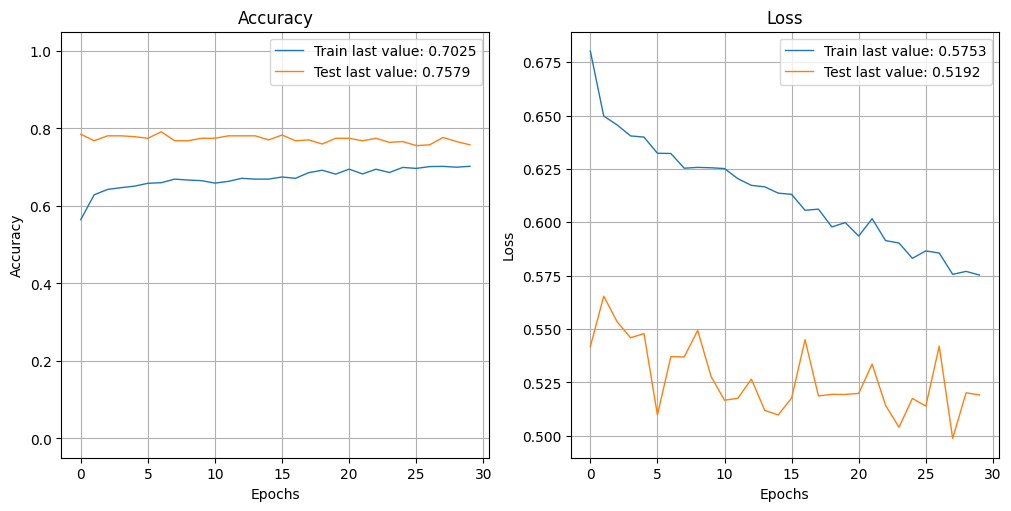

In [ ]:
hc_train_aug = np.concatenate((HC_train,X_pos_add,X_neg_add))
x_train_oe_aug = np.concatenate((X_train,oe_pos_add,oe_neg_add))
ACP_y_train_aug = np.concatenate((y_train,y_train)) # Concatenate 2D y_train

main_input = Input((maxlen,),dtype='int32',name='main_input')
x = Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=True)(main_input)
lstm_out = Bidirectional(LSTM(64))(x)
aux_len = hc_train_aug.shape[1]
aux_input = Input((aux_len,),name='aux_input')
x = layers.concatenate([lstm_out,aux_input])
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
main_output = Dense(1,activation='sigmoid',name='main_output')(x)
model = Model(inputs=[main_input,aux_input],outputs=main_output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

#train the model
hist = model.fit(x={'main_input':x_train_oe_aug,'aux_input':hc_train_aug}, y= ACP_y_train_aug,
                    #class_weight = class_weights_d,
                    epochs=30,
                    verbose=True,
                    validation_data=([X_val,HC_val],y_val),
                    batch_size=64).history

loss, accuracy = model.evaluate(x={'main_input':x_train_oe_aug,'aux_input':hc_train_aug}, y = ACP_y_train_aug, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x={'main_input':X_val,'aux_input':HC_val}, y = y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

import joblib

joblib.dump(model,filename='bilstm_attention_main7632.joblib')